**The first part of code is not one of the metric, its what I think is interessting when I plotting the data of but stop usage**
**4 part of codes are total bustop usage(sum usage of every stop), bustop usaage in each neighborhood, on time performance in each neighborhood, final score**
**All the data we get is longtitude and latitude, so we usse the fpsnippets providded**


Loading bus stop usage data from 'stop usage.csv'...
Successfully loaded 107611 usage records.
Processing time and usage data...
Aggregating total usage by month...
Data processing complete in 0.01 seconds.

--- Monthly Usage Totals (Sample) ---
  month_year  total_ons  total_offs
0 2019-09-01  3288458.0   3272838.0
1 2020-01-01  3041136.0   3029379.0
2 2020-09-01  1216205.0   1215933.0
3 2021-04-01  1313498.0   1308418.0
----------------------------------------

Generating time series plot...
Chart saved as 'monthly_total_usage.png'


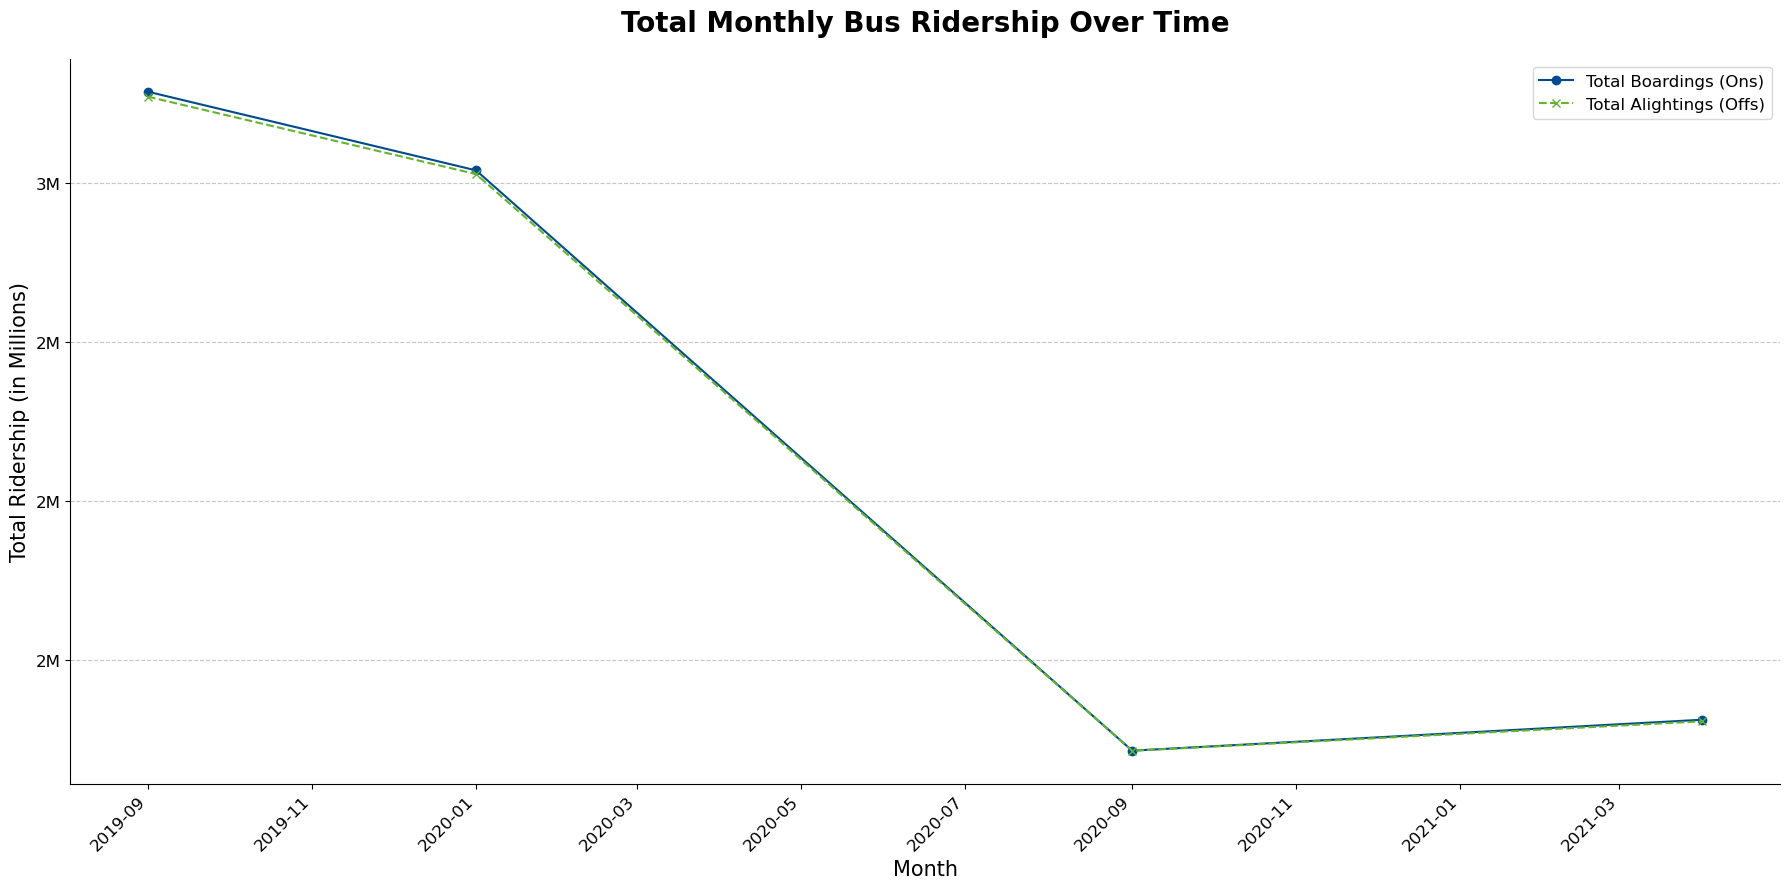

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import time

print("Loading bus stop usage data from 'stop usage.csv'...")
try:
    # Load the bus stop usage data
    df_usage = pd.read_csv("stop usage.csv", low_memory=False)
    print(f"Successfully loaded {len(df_usage)} usage records.")
except Exception as e:
    print(f"Error loading 'stop usage.csv'. Make sure it's in the same folder. Error: {e}")
    exit()

print("Processing time and usage data...")
start_time = time.time()

# --- Prepare the Data ---

# Check for necessary columns
if 'datekey' not in df_usage.columns:
    print("\n--- ERROR ---")
    print("Could not find 'datekey' column in 'stop usage.csv'.")
    print("This column is needed to analyze trends over time.")
    exit()
    
if 'total_ons' not in df_usage.columns or 'total_offs' not in df_usage.columns:
    print("\n--- ERROR ---")
    print("Could not find 'total_ons' or 'total_offs' columns in 'stop usage.csv'.")
    print("These columns are needed to calculate usage.")
    exit()
try:
    df_usage['month_year'] = pd.to_datetime(df_usage['datekey'], format='%Y%m')
except Exception as e:
    print(f"Error converting 'datekey' to datetime. Error: {e}")
    exit()

# --- Aggregate the Data ---
# Group by the new 'month_year' column and sum the total 'ons' and 'offs'
# This gives us the total city-wide ridership for each month.
print("Aggregating total usage by month...")
monthly_totals = df_usage.groupby('month_year')[['total_ons', 'total_offs']].sum().reset_index()

# Sort by date just to be safe
monthly_totals = monthly_totals.sort_values(by='month_year')

end_time = time.time()
print(f"Data processing complete in {end_time - start_time:.2f} seconds.")

print("\n--- Monthly Usage Totals (Sample) ---")
print(monthly_totals.head())
print("----------------------------------------")


# --- Plot the Time Series Chart ---
print("\nGenerating time series plot...")

plt.figure(figsize=(18, 9))  

# Plot the 'total_ons' over time
plt.plot(monthly_totals['month_year'], monthly_totals['total_ons'], 
         label='Total Boardings (Ons)', 
         color='#004B8D', # Blue
         marker='o', 
         linestyle='-')
# Plot the 'total_offs' over time
plt.plot(monthly_totals['month_year'], monthly_totals['total_offs'], 
         label='Total Alightings (Offs)', 
         color='#65B32E', # Green
         marker='x', 
         linestyle='--')

# --- Format the Plot ---
plt.title('Total Monthly Bus Ridership Over Time', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Month', fontsize=15)
plt.ylabel('Total Ridership (in Millions)', fontsize=15)

# Format the y-axis to show "10M" instead of "10,000,000"
def millions_formatter(x, pos):
    return f'{x/1000000:.0f}M'
plt.gca().get_yaxis().set_major_formatter(ticker.FuncFormatter(millions_formatter))

plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout() 

# Save the plot to a file
plt.savefig("monthly_total_usage.png")
print("Chart saved as 'monthly_total_usage.png'")

# Show the plot
plt.show()



Loading bus stop usage data from 'stop usage.csv'...
Successfully loaded 107611 usage records.
Initializing geographic data from fpsnippets...
Finding unique bus stops to map...
Found 6774 unique stops.
Mapping unique stops to neighborhoods... (This may take a minute or two)
Mapping complete in 20.01 seconds.
Merging neighborhood data into full usage dataset...
Aggregating total usage by neighborhood...

--- Top 20 Neighborhoods by Total Bus Stop Usage (All Time) ---
                           total_ons  total_offs  total_usage
neighborhood                                                 
Central Business District  2198762.0   2072641.0    4271403.0
North Oakland               553928.0    471530.0    1025458.0
Shadyside                   358903.0    402085.0     760988.0
Squirrel Hill North         291124.0    269454.0     560578.0
West Oakland                175213.0    274292.0     449505.0
Squirrel Hill South         190233.0    251502.0     441735.0
Central Oakland             2794

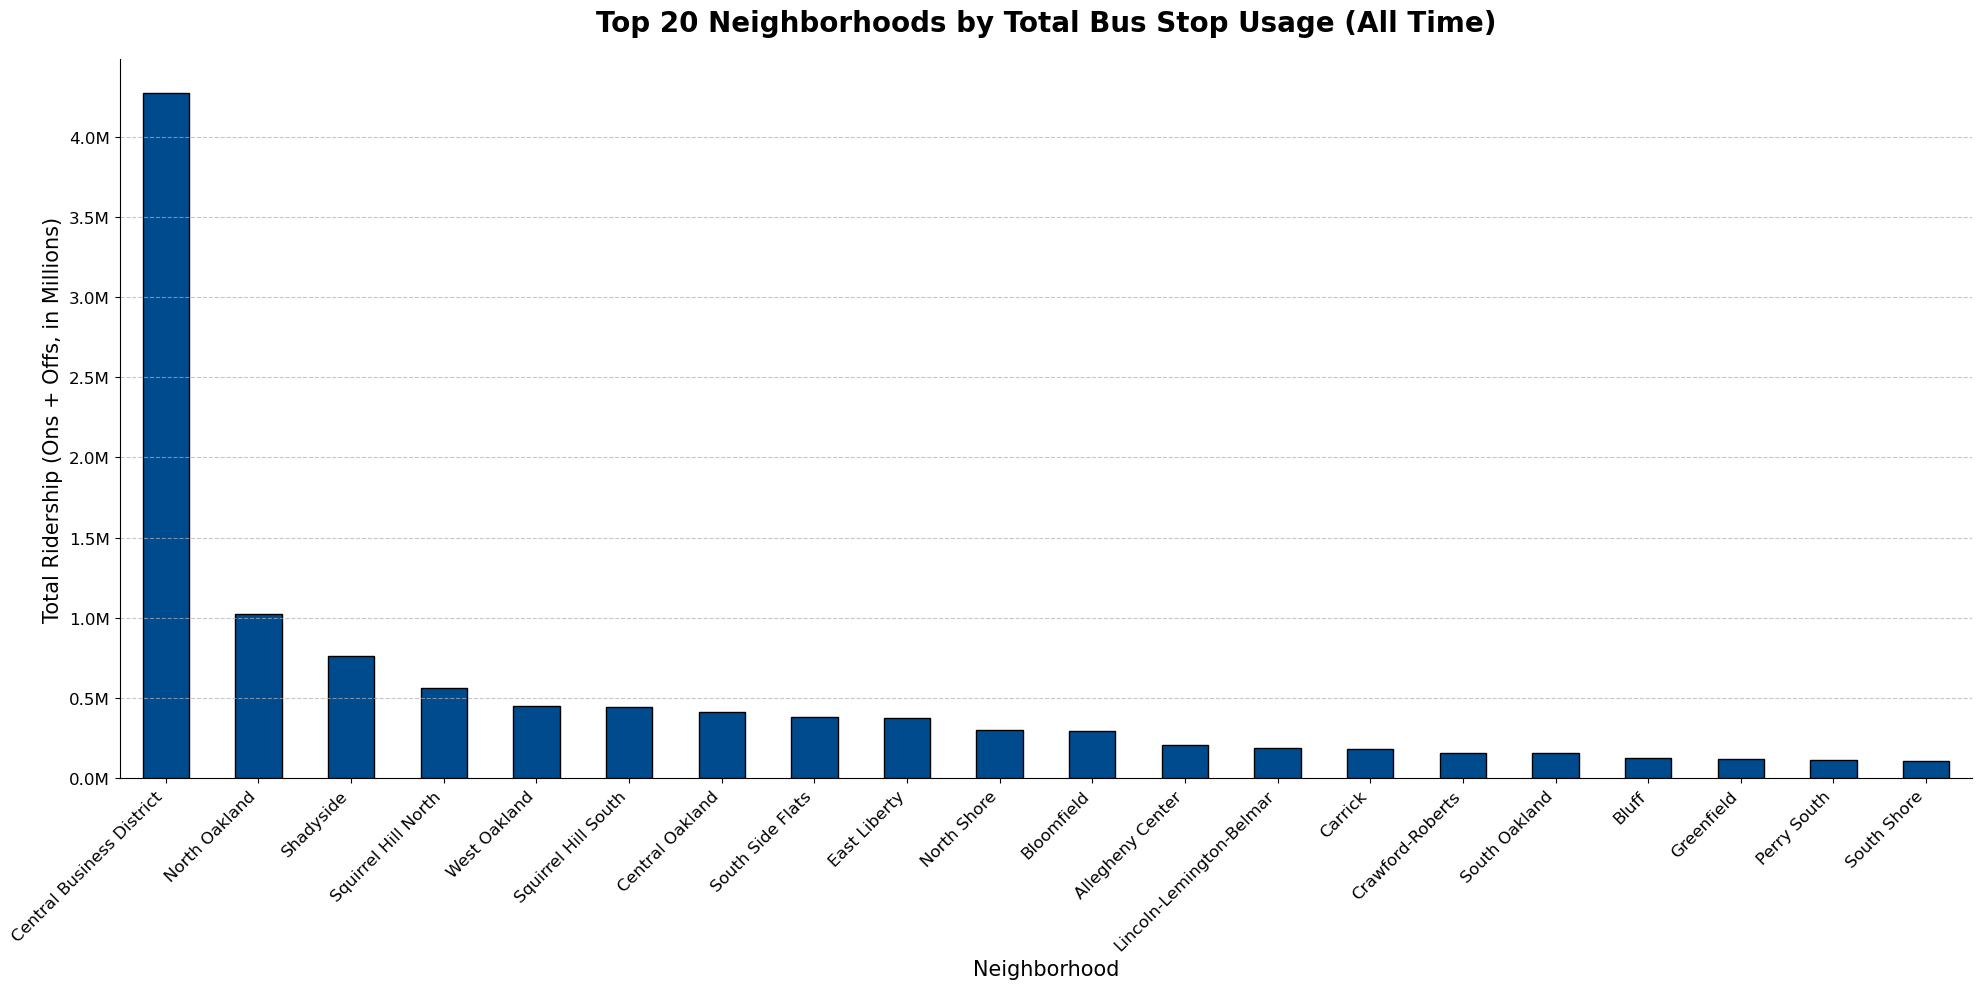

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import fpsnippets
import time

print("Loading bus stop usage data from 'stop usage.csv'...")
try:
    # Load the bus stop usage data
    df_usage = pd.read_csv("stop usage.csv", low_memory=False)
    print(f"Successfully loaded {len(df_usage)} usage records.")
except Exception as e:
    print(f"Error loading 'stop usage.csv'. Make sure it's in the same folder. Error: {e}")
    exit()

print("Initializing geographic data from fpsnippets...")

# --- Check for necessary columns ---
required_cols = ['stop_id', 'latitude', 'longitude', 'total_ons', 'total_offs']
if not all(col in df_usage.columns for col in required_cols):
    print("\n--- ERROR ---")
    print(f"The 'stop usage.csv' file is missing one or more required columns.")
    print(f"It must contain: {', '.join(required_cols)}")
    exit()

# --- Optimization: Map unique stops to neighborhoods ---
print("Finding unique bus stops to map...")
# Create a new DataFrame with just one entry for each unique stop_id
df_stops_unique = df_usage.drop_duplicates(subset=['stop_id'])
df_stops_unique = df_stops_unique[['stop_id', 'latitude', 'longitude']].copy()
print(f"Found {len(df_stops_unique)} unique stops.")

print("Mapping unique stops to neighborhoods... (This may take a minute or two)")
start_time = time.time()
# Apply the geo_to_neighborhood function to our unique stops
df_stops_unique['neighborhood'] = df_stops_unique.apply(
    lambda row: fpsnippets.geo_to_neighborhood(row['latitude'], row['longitude']),
    axis=1
)
end_time = time.time()
print(f"Mapping complete in {end_time - start_time:.2f} seconds.")

# --- Merge Mapped Data Back into Full Usage Data ---

# We only need the stop_id and the new neighborhood column
df_neighborhood_map = df_stops_unique[['stop_id', 'neighborhood']].dropna()

print("Merging neighborhood data into full usage dataset...")
# Merge the neighborhood name back onto every row in the original df_usage
df_usage_with_hoods = pd.merge(df_usage, df_neighborhood_map, on='stop_id')

# --- Aggregate Usage by Neighborhood ---
print("Aggregating total usage by neighborhood...")
# Group by neighborhood and sum the ons/offs for all time
neighborhood_usage = df_usage_with_hoods.groupby('neighborhood')[['total_ons', 'total_offs']].sum()

# Create a new 'total_usage' column
neighborhood_usage['total_usage'] = neighborhood_usage['total_ons'] + neighborhood_usage['total_offs']

# Sort by total usage and get the top 20
neighborhood_usage = neighborhood_usage.sort_values(by='total_usage', ascending=False)
top_20_usage = neighborhood_usage.head(20)

print("\n--- Top 20 Neighborhoods by Total Bus Stop Usage (All Time) ---")
print(top_20_usage)
print("---------------------------------------------------------------")

# --- Plot the Bar Chart ---
print("\nGenerating bar chart...")

plt.figure(figsize=(20, 10))  # Set a larger figure size
top_20_usage['total_usage'].plot(
    kind='bar', 
    color='#004B8D', # Blue
    edgecolor='black'
)

# --- Format the Plot ---
plt.title('Top 20 Neighborhoods by Total Bus Stop Usage (All Time)', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Neighborhood', fontsize=15)
plt.ylabel('Total Ridership (Ons + Offs, in Millions)', fontsize=15)

# Format the y-axis to show "10M" instead of 0000000000
def millions_formatter(x, pos):
    return f'{x/1000000:.1f}M'  
plt.gca().get_yaxis().set_major_formatter(ticker.FuncFormatter(millions_formatter))

plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout() 

# Save the plot to a file
plt.savefig("neighborhood_total_usage.png")
print("Chart saved as 'neighborhood_total_usage.png'")

# Show the plot
plt.show()

--- METRIC 3: RELIABILITY ANALYSIS ---
Mapping routes to neighborhoods...


/scratch/slurm-25730/ipykernel_4179718/1554094643.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mapped['routes_ser'] = df_mapped['routes_ser'].astype(str).str.replace(' ', '')
/scratch/slurm-25730/ipykernel_4179718/1554094643.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mapped['route_list'] = df_mapped['routes_ser'].str.split(',')


Graph saved as 'metric_3_reliability.png'


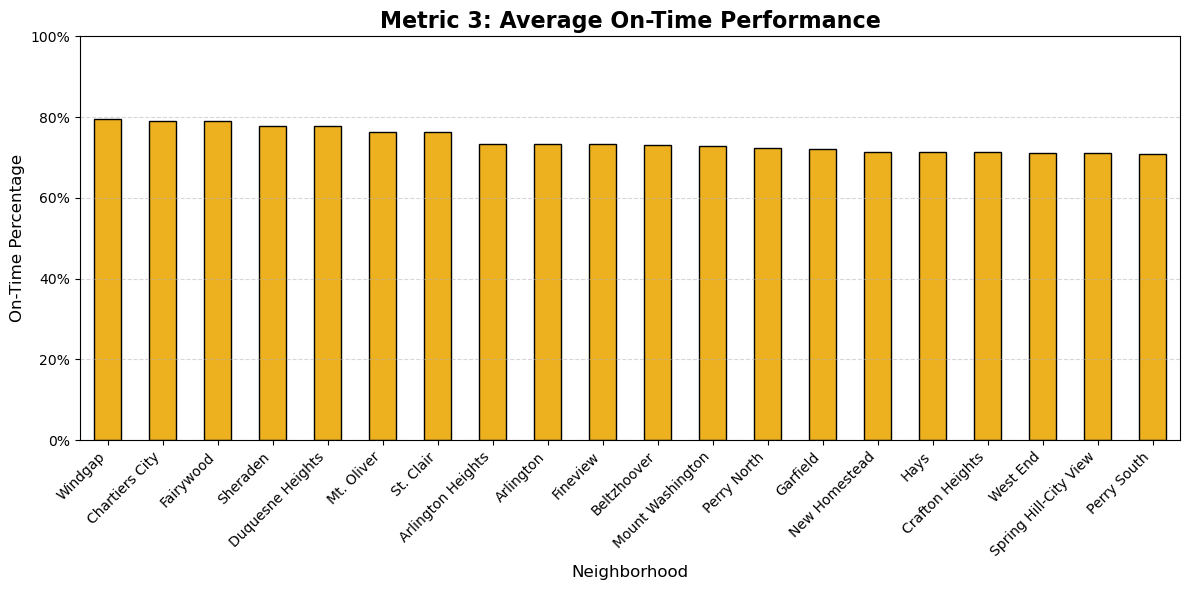

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import fpsnippets

print("--- METRIC 3: RELIABILITY ANALYSIS ---")

# Load Data
try:
    df_ontime = pd.read_csv("on time.csv", low_memory=False)
    df_usage = pd.read_csv("stop usage.csv", low_memory=False)
except FileNotFoundError:
    print("Error: Missing CSV files.")
    exit()

#Process On-Time Data
# Convert ratio (0.68) to percent (68.0)
df_ontime['on_time_percent'] = pd.to_numeric(df_ontime['on_time_percent'], errors='coerce') * 100
df_ontime = df_ontime.dropna(subset=['on_time_percent'])
df_ontime['route'] = df_ontime['route'].astype(str).str.strip()
# Get average reliability per route
route_reliability = df_ontime.groupby('route')['on_time_percent'].mean()

# Map Neighborhoods to Routes
print("Mapping routes to neighborhoods...")
# Get unique stops with route info
unique_stops = df_usage[['stop_id', 'latitude', 'longitude', 'routes_ser']].drop_duplicates(subset='stop_id')
unique_stops['neighborhood'] = unique_stops.apply(
    lambda row: fpsnippets.geo_to_neighborhood(row['latitude'], row['longitude']), 
    axis=1
)

df_mapped = unique_stops.dropna(subset=['neighborhood', 'routes_ser'])

# Explode routes (split "61A, 61B" -> separate rows)
df_mapped['routes_ser'] = df_mapped['routes_ser'].astype(str).str.replace(' ', '')
df_mapped['route_list'] = df_mapped['routes_ser'].str.split(',')
df_exploded = df_mapped.explode('route_list').rename(columns={'route_list': 'route'})

# Merge and Calculate
df_final = df_exploded.merge(route_reliability, on='route', how='inner')
neighborhood_reliability = df_final.groupby('neighborhood')['on_time_percent'].mean().sort_values(ascending=False)
top_20_reliability = neighborhood_reliability.head(20)

# Plot
plt.figure(figsize=(12, 6))
ax = top_20_reliability.plot(kind='bar', color='#EDB120', edgecolor='black')

plt.title('Metric 3: Average On-Time Performance', fontsize=16, fontweight='bold')
plt.xlabel('Neighborhood', fontsize=12)
plt.ylabel('On-Time Percentage', fontsize=12)

# Format Y-axis as percent
ax.yaxis.set_major_formatter(ticker.PercentFormatter())

plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.ylim(0, 100)
plt.tight_layout()

plt.savefig("metric_3_reliability.png")
print("Graph saved as 'metric_3_reliability.png'")
plt.show()

--- CALCULATING FINAL SCORES ---
Processing Stops...
Processing Usage...
Processing Reliability...
Normalizing Scores...
WINNER: Central Business District
Graph saved as 'final_score.png'


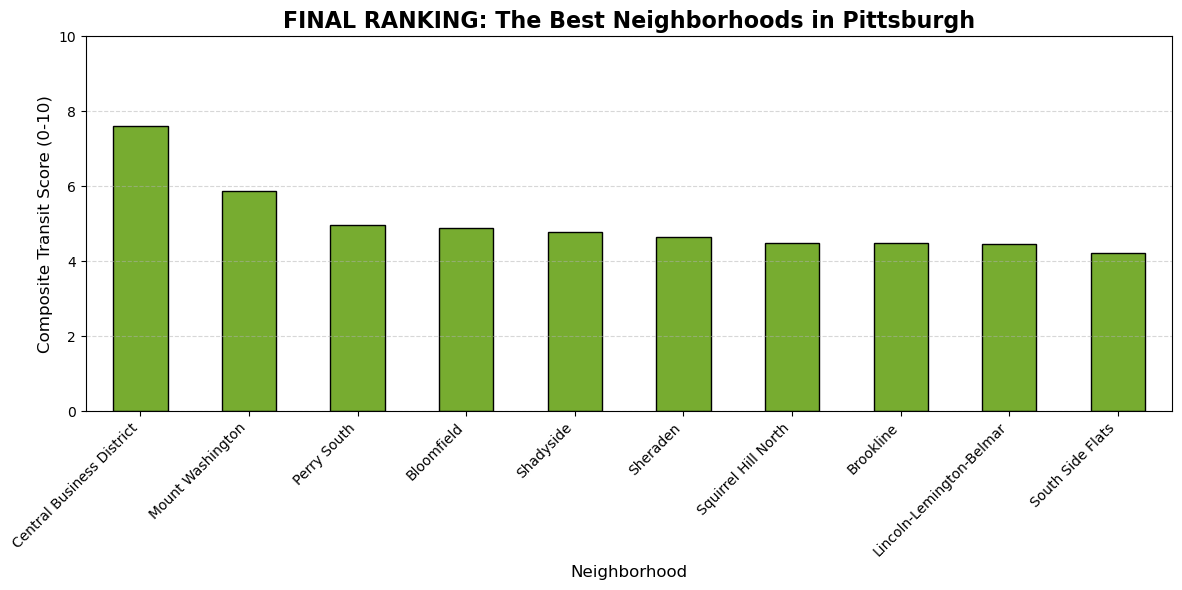

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import fpsnippets

print("--- CALCULATING FINAL SCORES ---")

# --- LOAD DATA ---
try:
    df_stops_raw = pd.read_csv("bus stop.csv", low_memory=False)
    df_usage_raw = pd.read_csv("stop usage.csv", low_memory=False)
    df_ontime_raw = pd.read_csv("on time.csv", low_memory=False)
except FileNotFoundError:
    print("Error: Missing one or more CSV files.")
    exit()

# --- HELPER: MAP NEIGHBORHOODS ---
def get_neighborhood_data(df, lat_col, lon_col):
    unique = df[[lat_col, lon_col]].drop_duplicates()
    unique['neighborhood'] = unique.apply(lambda x: fpsnippets.geo_to_neighborhood(x[lat_col], x[lon_col]), axis=1)
    return df.merge(unique, on=[lat_col, lon_col], how='left').dropna(subset=['neighborhood'])

# --- PROCESS METRIC 1: STOPS ---
print("Processing Stops...")
df_stops = get_neighborhood_data(df_stops_raw, 'LATITUDE', 'LONGITUDE')
metric_stops = df_stops['neighborhood'].value_counts()

# --- PROCESS METRIC 2: USAGE ---
print("Processing Usage...")
df_usage_unique = df_usage_raw.drop_duplicates(subset='stop_id')
df_usage_mapped = get_neighborhood_data(df_usage_unique, 'latitude', 'longitude')
# Merge back to full usage data to get totals
df_usage_full = df_usage_raw.merge(df_usage_mapped[['stop_id', 'neighborhood']], on='stop_id', how='inner')
df_usage_full['total'] = df_usage_full['total_ons'] + df_usage_full['total_offs']
metric_usage = df_usage_full.groupby('neighborhood')['total'].sum()

# --- PROCESS METRIC 3: RELIABILITY ---
print("Processing Reliability...")
df_ontime_raw['on_time_percent'] = pd.to_numeric(df_ontime_raw['on_time_percent'], errors='coerce') * 100
route_reli = df_ontime_raw.dropna(subset=['on_time_percent'])
route_reli['route'] = route_reli['route'].astype(str).str.strip()
avg_route_reli = route_reli.groupby('route')['on_time_percent'].mean()

# Link reliability to neighborhoods via usage data
df_routes = df_usage_mapped[['neighborhood', 'routes_ser']].dropna()
df_routes['routes_ser'] = df_routes['routes_ser'].astype(str).str.replace(' ', '')
df_exploded = df_routes.assign(route=df_routes['routes_ser'].str.split(',')).explode('route')
df_exploded['route'] = df_exploded['route'].str.strip()
df_merged_reli = df_exploded.merge(avg_route_reli, on='route', how='inner')
metric_reli = df_merged_reli.groupby('neighborhood')['on_time_percent'].mean()

# --- COMBINE & NORMALIZE ---
print("Normalizing Scores...")
final_df = pd.DataFrame(index=metric_stops.index)
final_df = final_df.join(metric_stops.rename("Stops"), how='inner')
final_df = final_df.join(metric_usage.rename("Usage"), how='inner')
final_df = final_df.join(metric_reli.rename("Reliability"), how='inner')

# Normalize to 0-10 Scale
# Formula: (x - min) / (max - min) * 10
for col in ['Stops', 'Usage', 'Reliability']:
    final_df[f'Score_{col}'] = (final_df[col] - final_df[col].min()) / \
                               (final_df[col].max() - final_df[col].min()) * 10

final_df['Final_Score'] = final_df[['Score_Stops', 'Score_Usage', 'Score_Reliability']].mean(axis=1)
final_df = final_df.sort_values(by='Final_Score', ascending=False).head(10)

# --- PLOT ---
print(f"WINNER: {final_df.index[0]}")

plt.figure(figsize=(12, 6))
final_df['Final_Score'].plot(kind='bar', color='#77AC30', edgecolor='black')

plt.title('FINAL RANKING: The Best Neighborhoods in Pittsburgh', fontsize=16, fontweight='bold')
plt.xlabel('Neighborhood', fontsize=12)
plt.ylabel('Composite Transit Score (0-10)', fontsize=12)
plt.ylim(0, 10)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.savefig("final_score.png")
print("Graph saved as 'final_score.png'")
plt.show()